In [ ]:
!pip install py7zr
!pip install datasketch

In [11]:
import py7zr

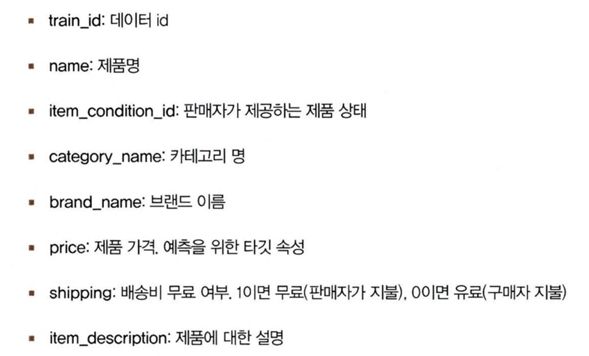

이 예제가 기존 회귀 예제와 다른 점은 item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다는 점이다.

# 데이터 전처리

In [19]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd


PATH = '/content/drive/MyDrive/ESAA/OB_dataset/'
WORKING_PATH = '/content/drive/MyDrive/ESAA/OB_dataset/'

# Extract the .7z file
with py7zr.SevenZipFile(f'{PATH}train.tsv.7z', mode='r') as z:
    z.extractall(path=WORKING_PATH)


# Read the extracted TSV file with encoding handling
mercari_df = pd.read_csv("/content/drive/MyDrive/ESAA/OB_dataset/train.tsv", sep="\t", encoding="utf-8")

print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [20]:
print(mercari_df.info()) # NULL 값 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


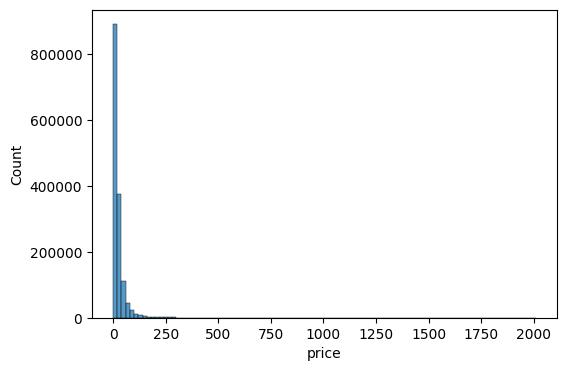

In [21]:
# Target값인 price 칼럼의 데이터 분포도 살펴보기
# 회귀에서 Target 값의 정규분포도는 매우 중요 (왜곡돼 있을 경우 로그 변환)

import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

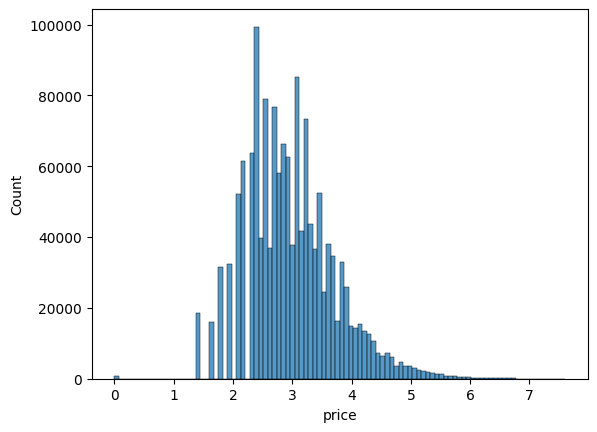

In [22]:
# 로그 변환해보기
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=100)
plt.show()

In [23]:
# 데이터의 price 칼럼을 원래 값에서 로그 변환으로 변경
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

,price
0,2.397895
1,3.970292
2,2.397895


In [24]:
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형:
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [25]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

np.int64(82489)

- category_name은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있다. (대분류/중분류/소분류) 여기서는 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습시키겠음.

In [26]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출하여 대,중,소 컬럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 갯수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


- brand_name, category_name, item_description 칼럼의 NULL 값은 일괄적으로 'Other Null'로 동일하게 변경함.

In [27]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,0
brand_name,0
price,0
shipping,0
item_description,0
cat_dae,0
cat_jung,0


# 피처 인코딩과 피처 벡터화

- 선형 회귀와 회귀 트리 모델을 모두 적용할 예정, 특히 선형 회귀의 경우 원-핫 인코딩이 훨씬 선호되므로 인코딩할 피처는 원-핫 인코딩을 적용!
- 피처 벡터화의 경우, 비교적 짧은 텍스트의 경우 Count 기반, 긴 텍스트는 TD-IDF 기반의 벡터화 적용

- brand_name

In [28]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


brand_name의 경우 대부분 명료한 문자열로 돼 있음. 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용하면 됨. 원핫인코딩을 하기엔 종류가 4810건으로 다소 많아보이나 ML 모델 구축상 큰 문제 X

- name

In [29]:
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 갯수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count 기반으로 피처 벡터화 변환을 적용

- category_name

이전에 전처리를 통해서 대, 중, 소 세 개의 칼럼은 cat_dae, cat_jung, cat_so 칼럼으로 분리됐음. 이것들도 원핫인코딩 적용

- shipping(0,1), item_condition_id(1~5)

원핫인코딩 진행

- item_description

In [30]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.71139703278507


,item_description
0,No description yet
1,This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.


평균 문자열이 145자로 비교적 크므로 해당 칼럼은 TF-IDF로 변환



---



이제 name과 item_description 칼럼을 피처 벡터화함. name의 경우 CountVectorizer, item_description의 경우 TfidfVectorizer로 변환

In [31]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features= 5000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:',X_name.shape)
print('item_description vectorization shape:',X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 5000)


- ➡️ CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태다. 따라서 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합하도록 하겠음.
- ➡️ 사이킷런은 원핫인코딩을 위해 OneHotEncoder와 LabelBinarizer 클래스를 제공한다. 이중 LabelBinarizer는 희소 행렬 형태의 원핫인코딩 변환을 지원한다. (sparse_ount=True) 따라서 모든 인코딩 대상 칼럼은 LabelBinarizer를 이용해 희소 행렬 형태의 원핫인코딩으로 변환하고, 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용해 결합하겠다


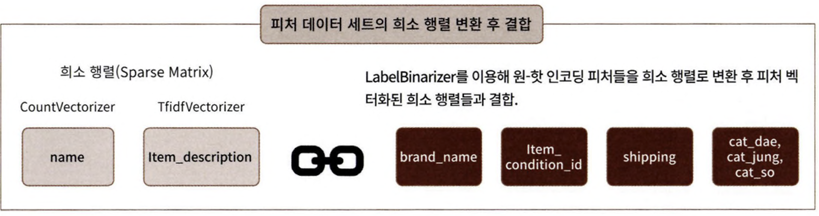

In [33]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원핫인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [34]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)




---



이번엔 앞에서 만든 데이터 세트를 hstack()을 이용하여 모두 결합해보겠다.

In [35]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제.
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 116569)


8

# 릿지 회귀 모델 구축 및 평가

모델의 평가 지표는 캐글에서 제시한 RMSLE임 (오류값에 로그를 취해 RMSE를 구하는 방식)

주의할 점: 전처리 단계에서 price를 로그 변환했으므로 exmpm1로 원복해야 함

In [36]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds):

    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요.
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [37]:
import gc
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)

    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)

    del X , X_train , X_test , y_train
    gc.collect()

    return preds , y_test

- 🤔 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 예측 성능을 비교해보자

[릿지]

In [38]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함한 rmsle 값: 0.4766414601886098


-> item_description을 포함했을 때 rmsle 값이 많이 감소했음

# LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=100, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


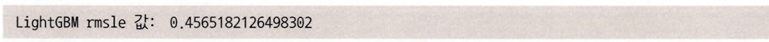

-> 앞 ridge보다 예측 성능이 더 나아졌음. lightgbm의 예측 결괏값과 ridge의 예측 결괏값을 서로 앙상블해 최종 예측 결괏값을 도출하겠음. 배율은 임의로 산정함.

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

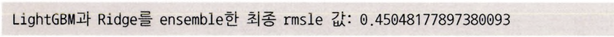